In [11]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.lines import Line2D

from Mytorch import nn, optim, tensor, loss
from Mytorch.nn.sequential import Sequential
from Mytorch.nn.linear import Linear
from Mytorch.nn.conv2d import Conv2d
from Mytorch.nn.flatten import Flatten
from Mytorch.nn.maxpool import Maxpool
from Mytorch.nn.activation_function import *
from Mytorch.loss.lossFunction import CrossEntropy, MSE
from Mytorch.evaluator.performance import ClassificationPerformance
from Mytorch.optim.sgd import SGD

## 定义准确率函数

In [12]:
def accuracy(a, y):
    size = a.shape[0]
    idx_a = np.argmax(a, axis=1)
    idx_y = np.argmax(y, axis=1)
    acc = sum(idx_a == idx_y)
    return acc

## 加载数据

In [13]:
m = loadmat("minst/mnist_small_matlab.mat")

trainData, train_labels = m['trainData'], m['trainLabels']
testData, test_labels = m['testData'], m['testLabels']
train_images = trainData.reshape(-1, 10000).transpose(1, 0)
train_labels = train_labels.transpose(1, 0)
test_images = testData.reshape(-1, 2000).transpose(1, 0)
test_labels = test_labels.transpose(1, 0) 
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(10000, 784)
(10000, 10)
(2000, 784)
(2000, 10)


## 定义网络结构

In [14]:
# 初始化各层及激活函数
conv1 = Conv2d("conv1",intputChannal=1,outputChnnal=3,stride=1,padding=1,kernel_size=(3,3))
f1 = Relu("f1")
maxpool1 = Maxpool("maxpoo1", size = 2, stride = 2)
conv2 = Conv2d("conv2",intputChannal=3,outputChnnal=6,stride=1,padding=1,kernel_size=(3,3)) 
f2 = Relu("f2")
maxpool2 =Maxpool("maxpoo2", size = 2, stride = 2)
linear1 = Linear("linear1", 7 * 7 * 6, 128) 
f3 = Relu("f3")
linear2 = Linear("linear2", 128, 10)
f4 = SoftMax("f4")


# 构建网络
model = Sequential("model")
model.add_module(conv1)
model.add_module(maxpool1)
model.add_module(f1)
model.add_module(conv2)
model.add_module(maxpool2)
model.add_module(f2)
model.add_module(linear1)
model.add_module(f3)
model.add_module(linear2)
model.add_module(f4)



**********************************
network: odict_keys(['conv1', 'maxpoo1', 'f1', 'conv2', 'maxpoo2', 'f2', 'linear1', 'f3', 'linear2', 'f4'])
w_dict: odict_keys(['conv1', 'conv2', 'linear1', 'linear2'])
b_dict: odict_keys(['conv1', 'conv2', 'linear1', 'linear2'])
z_dict: odict_keys(['f1', 'f2', 'f3', 'f4'])
a_dict: odict_keys(['f1', 'f2', 'f3', 'f4'])
**********************************




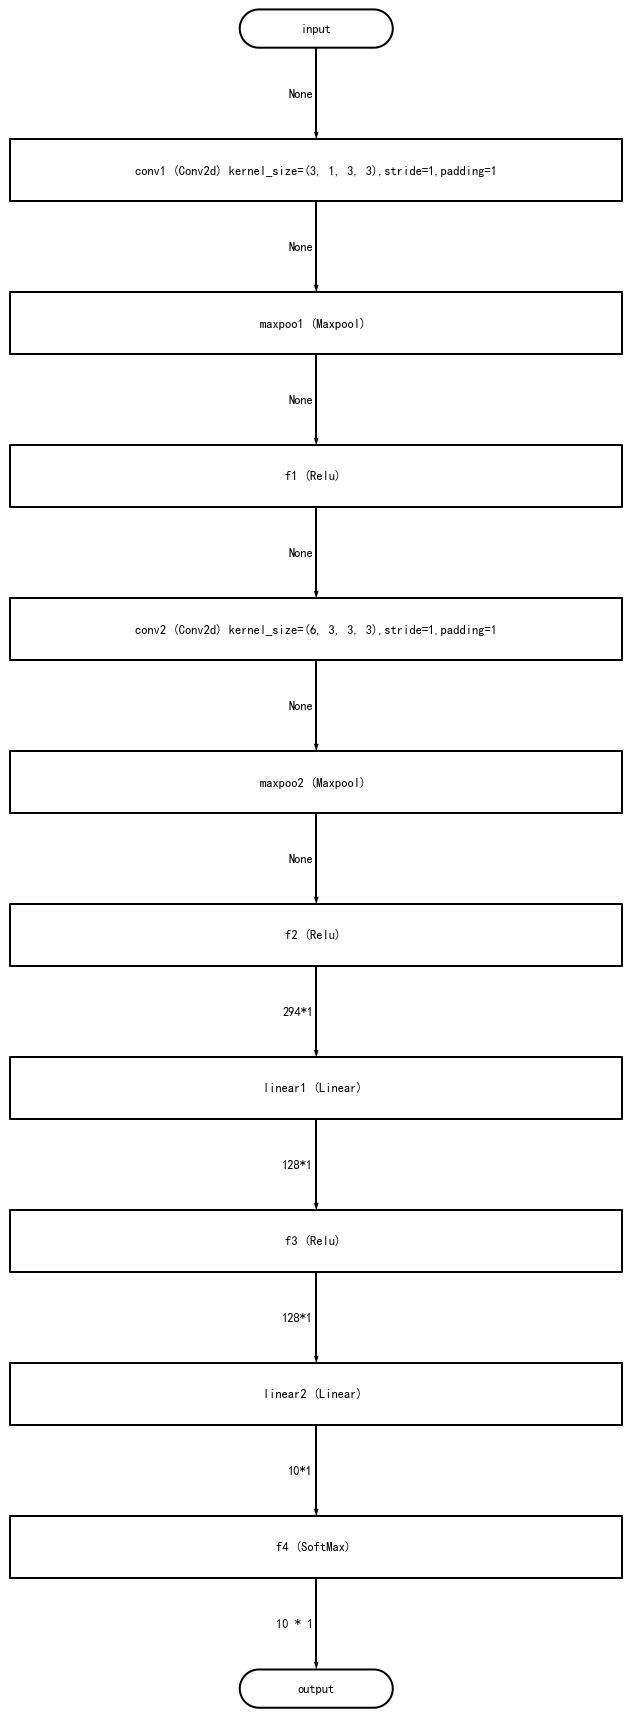

In [15]:
# 可视化网络结构
model.show()

## 训练

In [16]:
optimizer = SGD(model, lr=0.05)
criterion = CrossEntropy()

E_list = []
train_Loss_list = []
train_acc_list = []
test_Loss_list = []
test_acc_list = []
batch_size = 100
max_epoch = 20
for epoch in range(max_epoch):
    E_list.append(epoch)
    
    model.train()
    sample_idxs = np.random.permutation(train_images.shape[0])
    num_batch = int(np.ceil(train_images.shape[0]/batch_size))
    train_cost = 0
    acc = 0
    for batch_idx in range(num_batch):
        x = Tensor(train_images[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),train_images.shape[0])],:])
        y = Tensor(train_labels[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),train_labels.shape[0])],:])
        x = x.reshape((x.shape[0],1,28,28))
        y_pred = model(x)
        y_pre = y_pred.datas
        acc += accuracy(y, y_pre)
        optimizer.zero_grad()
        loss = criterion(y_pred,y)
        train_cost += loss.datas 
        loss.backward()
        optimizer.step()
    
    train_cost /= train_images.shape[0]
    acc /= train_images.shape[0]
    train_Loss_list.append(train_cost) 
    train_acc_list.append(acc)


    model.eval()
    sample_idxs = np.random.permutation(test_images.shape[0])
    num_batch = int(np.ceil(test_images.shape[0]/batch_size))
    acc = 0
    test_cost = 0
    for batch_idx in range(num_batch):
            x = Tensor(test_images[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),test_images.shape[0])],:])
            y = Tensor(test_labels[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),test_labels.shape[0])],:])
            x = x.reshape((x.shape[0],1,28,28))
            y_pre = model(x)
            loss = criterion(y_pre ,y)
            test_cost += loss.datas
            y_pre = y_pre.datas
            acc += accuracy(y, y_pre)
    acc /= test_labels.shape[0]
    test_cost /= test_images.shape[0]
    test_Loss_list.append(test_cost) 
    test_acc_list.append(acc)
    print("epoch= ",epoch," train cost = ",train_Loss_list[-1],"acc on traintset = ",train_acc_list[-1], "\ntest cost = ",test_Loss_list[-1],"acc on testtset = ",test_acc_list[-1])

epoch=  0  train cost =  10.297418912862407 acc on traintset =  0.0983 
test cost =  10.447978934465109 acc on testtset =  0.0925
epoch=  1  train cost =  10.371993560396634 acc on traintset =  0.0991 
test cost =  10.447978934465105 acc on testtset =  0.0925
epoch=  2  train cost =  10.371993560396627 acc on traintset =  0.0991 
test cost =  10.447978934465107 acc on testtset =  0.0925
epoch=  3  train cost =  10.371993560396639 acc on traintset =  0.0991 
test cost =  10.447978934465107 acc on testtset =  0.0925


## 绘制图片

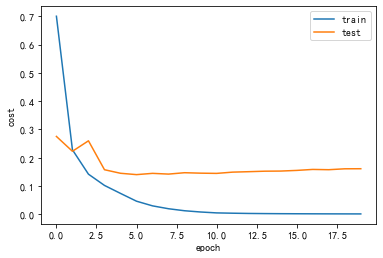

In [ ]:
# 绘制cost
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(train_Loss_list, label = "train")
plt.plot(test_Loss_list, label = "test")
plt.legend()
plt.savefig("cost_of_train_and_test.png", dpi = 200)

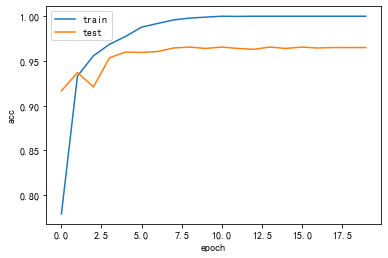

In [ ]:
# 绘制acc
plt.xlabel("epoch")
plt.ylabel("acc")
plt.plot(train_acc_list, label = "train")
plt.plot(test_acc_list, label = "test")
plt.legend()
plt.savefig("acc_of_train_and_test.png", dpi = 200)

## 评估性能

In [ ]:
model.eval()
y_pred_list = []
y_real_list = []
for i in range(test_images.shape[0]):
        x = Tensor(test_images[i])
        y_read = Tensor(test_labels[i])
        x = x.reshape((1,1,28,28))
        y_pred = model(x)
        y_pred_list.append(np.argmax(y_pred.datas))
        y_real_list.append(np.argmax(y_read.datas))

显示百分比：
[[ 0.98  0.00  0.00  0.00  0.00  0.00  0.01  0.00  0.00  0.00]
 [ 0.00  0.93  0.01  0.01  0.01  0.00  0.00  0.00  0.04  0.00]
 [ 0.02  0.01  0.94  0.02  0.01  0.00  0.00  0.01  0.01  0.00]
 [ 0.00  0.00  0.01  0.98  0.00  0.01  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.96  0.00  0.00  0.00  0.00  0.02]
 [ 0.00  0.00  0.00  0.01  0.00  0.99  0.00  0.00  0.00  0.01]
 [ 0.01  0.00  0.00  0.01  0.01  0.00  0.97  0.01  0.01  0.00]
 [ 0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.98  0.00  0.00]
 [ 0.00  0.01  0.00  0.02  0.00  0.01  0.00  0.00  0.97  0.01]
 [ 0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.00  0.01  0.96]]


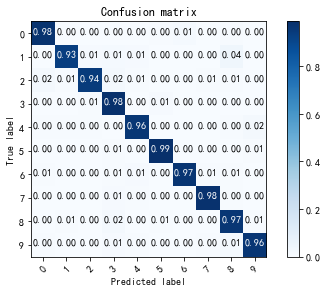

In [ ]:
cp = ClassificationPerformance(y_pred_list, y_real_list, 10)
cp.showConfusionMatrix()

In [ ]:
print("各类别召回率：",cp.getRecall(), "平均召回率:", np.average(cp.getRecall()))
print("各类别精确率：",cp.getPrecision(), "平均精确率:", np.average(cp.getPrecision()))
print("各类别F1分数：",cp.getF1Score(), "平均精确率:", np.average(cp.getF1Score()))
print("平均准确率:", cp.getAccuracy())

各类别召回率： [ 0.98  0.93  0.94  0.98  0.96  0.99  0.97  0.98  0.97  0.96] 平均召回率: 0.9663086634056336
各类别精确率： [ 0.97  0.99  0.98  0.92  0.97  0.98  0.98  0.99  0.91  0.97] 平均精确率: 0.964752809226056
各类别F1分数： [ 0.97  0.96  0.96  0.95  0.96  0.98  0.98  0.98  0.94  0.97] 平均精确率: 0.965207100842101
平均准确率: 0.9655
